In [2]:
import tifffile as tiff
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import pandas as pd
import os
from PIL import Image
import re
import csv
import shutil
from skimage.morphology import dilation, erosion
from tqdm import tqdm
from scipy.spatial.distance import cdist
import numba

In [5]:
gt_folder = '/home/MinaHossain/DMNet_Rina_Tracking/6row_images/02_GT/SEG'
pred_folder = '/home/MinaHossain/DMNet_Rina_Tracking/6row_images/02_RES'

In [21]:
frame = 173

gt_seg = Image.open(os.path.join(gt_folder, f"man_seg{frame:04d}.tif"))
gt_seg = np.array(gt_seg)
pred_seg = Image.open(os.path.join(pred_folder, f"mask{frame:04d}.tif"))
pred_seg = np.array(pred_seg)

array([    0,  2691,  3298,  5494,  6255,  7061,  7317,  7501,  7603,
        7682,  7982,  8036,  8310,  8311,  8330,  8554,  8560,  8611,
        8643,  8849,  8871,  8884,  8903,  8908,  8933,  8968,  8969,
        8997,  9050,  9118,  9142,  9304,  9318,  9336,  9341,  9342,
        9376,  9452,  9504,  9506,  9545,  9546,  9572,  9614,  9624,
        9628,  9665,  9667,  9674,  9680,  9692,  9693,  9718,  9722,
        9740,  9781,  9833,  9858,  9867,  9868,  9869,  9873,  9893,
        9901,  9908,  9921,  9956,  9963,  9977,  9979, 10004, 10023,
       10024, 10033, 10043, 10044, 10047, 10049, 10050, 10071, 10075,
       10082, 10096, 10103, 10108, 10109, 10129, 10135, 10136, 10137,
       10149, 10150, 10190, 10191, 10199, 10211, 10212, 10215, 10216,
       10236, 10237, 10289, 10291, 10300, 10301, 10320, 10341, 10342,
       10350, 10351, 10365, 10366, 10367, 10368, 10370, 10371, 10373,
       10395, 10404, 10405, 10408, 10409, 10416, 10417, 10420, 10421,
       10428, 10430]

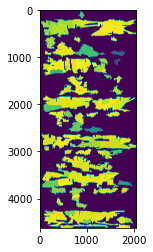

In [22]:
plt.imshow(pred_seg)
np.unique(pred_seg)

In [13]:
gt_centers = []

for label in np.unique(gt_seg):
    if label != 0:
        inds = np.argwhere(gt_seg == label)
        loc = inds.mean(0)
        gt_centers.append(loc)
gt_centers = np.asarray(gt_centers)

In [14]:
pred_centers = []

for label in np.unique(pred_seg):
    if label != 0:
        inds = np.argwhere(pred_seg == label)
        loc = inds.mean(0)
        pred_centers.append(loc)
pred_centers = np.asarray(pred_centers)

In [15]:
gt_centers.shape[0], pred_centers.shape[0]

(40, 1)

In [3]:
distances = cdist(gt_centers, pred_centers)

NameError: name 'gt_centers' is not defined

In [10]:
min_distances = np.min(distances, axis=0)

In [11]:
final_score = np.median(min_distances)
print(f"The median minimum (L_2) center distance is {final_score:.4f}")

The median minimum (L_2) center distance is 191.1596


In [2]:
import numpy as np
import os
from PIL import Image
from tqdm import tqdm
from scipy.spatial.distance import cdist
import numba

@numba.njit()
def get_cell_centers(seg):
    labels = np.unique(seg)
    centers = np.zeros((labels.shape[0]-1, 2))
    idx = 0
    for label in labels:
        if label != 0:
            inds = np.argwhere(seg == label)
            loc_x = np.mean(inds[:, 0])
            loc_y = np.mean(inds[:, 1])
            centers[idx, 0] = loc_x
            centers[idx, 1] = loc_y
            idx += 1
    return centers

def calculate_score(gt_centers, pred_centers):
    return np.mean(cdist(gt_centers, pred_centers).min(0))

def count_frames(gt_folder, targ_ext=['.tif']):
    total = 0
    for filename in os.listdir(gt_folder):
        fname, ext = os.path.splitext(filename)
        total += ext in targ_ext
    return total

def open_frame(frame, folder, name_root):
    seg = Image.open(os.path.join(folder, f"{name_root}{frame:04d}.tif")).convert("L")
    return np.array(seg)


gt_folder = '/home/MinaHossain/DMNet_Rina_Tracking/6row_images/02_GT/SEG'
pred_folder = '/home/MinaHossain/DMNet_Rina_Tracking/6row_images/02_RES'
n_frames = count_frames(gt_folder)

scores = []
pbar = tqdm(range(n_frames))
for frame in pbar:
    gt_frame = open_frame(frame, gt_folder, "man_seg")
    seg_frame = open_frame(frame, pred_folder, "mask")
    gt_centers = get_cell_centers(gt_frame)
    seg_centers = get_cell_centers(seg_frame)
    score = calculate_score(gt_centers, seg_centers)
    pbar.set_description(f"Frame: {frame}, Score: {score:.1f}")
    scores.append(score)


Frame: 210, Score: 319.3: 100%|██████████| 211/211 [02:22<00:00,  1.48it/s]


In [23]:
num_digits = 4
eval(f"print(f'Scores: {np.mean(scores)}')")

Scores: 311.41844076307325
